<a href="https://colab.research.google.com/github/eduguiu/slightdata/blob/master/Detectron2_DatasetPrepare_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation for Detectron2

This Notebooks performs the following actions: 
- get [OIDC v4](https://github.com/EscVM/OIDv4_ToolKit)
- download a given class (possibly many)
- Generate a Folder with a csv explanatory file and many images that will be loaded onto a dictionaries : MetadataCatalog /  DatasetCatalog 

The treemap is as follows: 
- Dataset 
    - **train_folder (.jpg images within)**
    - train_labels.csv
    - **test_folder (.jpg images within)**
    - test_labels.csv



## Libraries

In [0]:
import pandas as pd
import numpy as np 
import os
import cv2
import os
from pathlib import Path
import sys
import json
from google.colab.patches import cv2_imshow

## Custom Functions

In [0]:
def createDFP(direct, categ='Street_light'):
    '''
    this function generates the DataFrame of all the images within, returns img_ix, filename, Height and Width.
    the input is a working str with the folder path containing images. 
    Needs to input directory (direct) where images are, and class (categ=)
    ver 2.0
    '''
    LST=[]
    ls=[]
    # list all the files present in the folder Direct
    ls = sorted([k for k in os.listdir(direct) if 'jpg' in k])
    for i in range(len(ls)): 
        fn = os.path.join(direct + '/' + ls[i])
        im = cv2.imread(fn)
        h,w,_ = im.shape
        dictL = {'idx_img':i+1,
                'ImageID': ls[i].rstrip(".jpg"),
                 'height': h,
                 'width': w,
                 'class': categ}
        LST.append(dictL)
    dfp= pd.DataFrame(LST)
    return dfp

In [0]:
# second version of the merge DF 
def Merge_DF(dfa, dfp):
    ''' pass on the df Annotations and the df Pictures in folder. 
    this function gives back a merged df with all the annotations to the present 
    pictures with id, Height, width, and real postion of BBOX
    '''
    df_F = dfa.merge(dfp[['ImageID', 'idx_img', 'height', 'width', 'class']],
                  on = 'ImageID' ,
                  how = 'inner', 
                  suffixes=("_Ann", "_Pic"))
    # the index is reset to start at position 1. 
    df_F.index=range(1, len(df_F)+1)

    df_F['xmin']= (df_F['XMin'] * df_F['width']).astype(int)
    df_F['xmax']= (df_F['XMax'] * df_F['width']).astype(int)
    df_F['ymin']= (df_F['YMin'] * df_F['height']).astype(int)
    df_F['ymax']= (df_F['YMax'] * df_F['height']).astype(int)

    # drop useless columns
    df_F.drop(columns=['Confidence', 'XMin', 'YMin', 'XMax', 'YMax'], inplace=True)
    
    return df_F

# **GetCSVData**

## Define parameters

Folders, classes etc..

In [30]:
ORIGIN_PATH='/content/drive/My Drive/RCNN/OIDCv4_v1/Dataset/test/Street light'
DESTINATION_PATH = '/content/drive/My Drive/RCNN/'

classes = ['Street_light']
FLAVOUR = 'test' # can be 'train', 'test' of 'validation'
FOLDER_PICS = '/content/drive/My Drive/RCNN/slight_red/' + FLAVOUR + '/images'
FOLDER_OUT = '/content/drive/My Drive/RCNN/slight_red/'
FOLDER_OUT

'/content/drive/My Drive/RCNN/slight_red/'

## DFA definition

Data from the 1,7 M annotations from OIDCv4 is loaded onto a DataFrame. 

In [31]:
df= pd.read_csv('/content/drive/My Drive/RCNN/OIDCv4_v1/csv_folder/'+ FLAVOUR+'-annotations-bbox.csv') # nrows=10000)
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,freeform,/m/07j7r,1,0.071905,0.145346,0.206591,0.391306,0,1,1,0,0
1,000026e7ee790996,freeform,/m/07j7r,1,0.439756,0.572466,0.264153,0.435122,0,1,1,0,0
2,000026e7ee790996,freeform,/m/07j7r,1,0.668455,1.000000,0.000000,0.552825,0,1,1,0,0
3,000062a39995e348,freeform,/m/015p6,1,0.205719,0.849912,0.154144,1.000000,0,0,0,0,0
4,000062a39995e348,freeform,/m/05s2s,1,0.137133,0.377634,0.000000,0.884185,1,1,0,0,0


The values of the desired categories (Street light, traffic light, Traffic Sign, Light Bulb) can be sumarised in a dictionnary. 
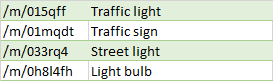

In [32]:
myCategories={'/m/015qff': 'Traffic_light', '/m/01mqdt' : 'Traffic_sign', '/m/033rq4' : 'Street_light', '/m/0h8l4fh':'Light_bulb' }
myCategories2={'/m/015qff': ['Traffic_light',1], 
               '/m/01mqdt' : ['Traffic_sign',2],
               '/m/033rq4' : ['Street_light', 3], 
               '/m/0h8l4fh': ['Light_bulb',4]}
dfa=df.loc[df['LabelName'].isin(list(myCategories2))]
print("number of annotations   : ", dfa.shape[0], "\n",
      "number of unique images : ", dfa.ImageID.unique().shape[0])

number of annotations   :  492 
 number of unique images :  167


The annotations df is filtered related to the desired category

In [33]:
dfa_S= (dfa.loc[dfa['LabelName'] == '/m/033rq4']).drop(columns=['Source','IsOccluded','IsDepiction', 'IsInside', 'IsGroupOf', 'IsTruncated'], axis=1)
dfa_S.head()

,ImageID,LabelName,Confidence,XMin,XMax,YMin,YMax
10473,03b29a57611ad70e,/m/033rq4,1,0.317103,0.366145,0.467062,0.929064
10474,03b29a57611ad70e,/m/033rq4,1,0.589429,0.614238,0.600548,0.823315
10475,03b29a57611ad70e,/m/033rq4,1,0.665588,0.682897,0.634353,0.790377
32346,0bd3d413eb90a326,/m/033rq4,1,0.126585,0.135598,0.245906,0.356643
32347,0bd3d413eb90a326,/m/033rq4,1,0.230240,0.290115,0.118859,0.457079


In [34]:
# the original Index from the CSV is kept at "idx_orig" and a new index is reset 
# starting at 1. 
dfa_SL = dfa_S.reset_index().rename(columns={'index': 'idx_orig'})
dfa_SL.index=range(1, len(dfa_SL)+1) 
dfa_SL.head(), dfa_SL.shape

(   idx_orig           ImageID  LabelName  ...      XMax      YMin      YMax
 1     10473  03b29a57611ad70e  /m/033rq4  ...  0.366145  0.467062  0.929064
 2     10474  03b29a57611ad70e  /m/033rq4  ...  0.614238  0.600548  0.823315
 3     10475  03b29a57611ad70e  /m/033rq4  ...  0.682897  0.634353  0.790377
 4     32346  0bd3d413eb90a326  /m/033rq4  ...  0.135598  0.245906  0.356643
 5     32347  0bd3d413eb90a326  /m/033rq4  ...  0.290115  0.118859  0.457079
 
 [5 rows x 8 columns], (242, 8))

## DFP definition

We create a DataFrame (dfp) with all the names, Height, Width and category of the images in a given Directory with the function **createDFP(dir)**

In [35]:
dfp_SL = createDFP(FOLDER_PICS)
dfp_SL.head()

,idx_img,ImageID,height,width,class
0,1,03b29a57611ad70e,682,1024,Street_light
1,2,0bd3d413eb90a326,768,1024,Street_light
2,3,0e88c20dd40e6b87,657,1024,Street_light
3,4,1b52e64a6c5a652e,1024,670,Street_light
4,5,2bc5e1bb91dbca92,1024,768,Street_light


## Merge Both DFs

We merge the dfa with the info from dfp prior to creating the json file. 

In [36]:
df_Dst = Merge_DF(dfa_SL, dfp_SL)
df_out = df_Dst.drop(columns=['idx_orig', 'LabelName']).rename(columns={'ImageID': 'filename', 'idx_img':'image_id'})
df_out['filename'] = df_out['filename'].apply(lambda x: f"{x}.jpg")
df_out.head()

,filename,image_id,height,width,class,xmin,xmax,ymin,ymax
1,03b29a57611ad70e.jpg,1,682,1024,Street_light,324,374,318,633
2,03b29a57611ad70e.jpg,1,682,1024,Street_light,603,628,409,561
3,03b29a57611ad70e.jpg,1,682,1024,Street_light,681,699,432,539
4,0bd3d413eb90a326.jpg,2,768,1024,Street_light,129,138,188,273
5,0bd3d413eb90a326.jpg,2,768,1024,Street_light,235,297,91,351


# Write CSV

In [0]:
df_out.to_csv(FOLDER_OUT + FLAVOUR +'_labels.csv', header=True)

In [0]:
!ls '/content/drive/My Drive/RCNN/OIDCv4_v1/Dataset/test/Street light/'

03b29a57611ad70e.jpg  5dc9465b0bad69fc.jpg  b67924cca177725a.jpg
0bd3d413eb90a326.jpg  6045369b5a067cbe.jpg  b752f97c3b88d4f4.jpg
0e88c20dd40e6b87.jpg  63cbeba5233632ad.jpg  bdd6fd042dec9f9f.jpg
15362b7c65f87cc4.jpg  6a23839d173029a4.jpg  c4677dc9811daf71.jpg
16c912d7bfb98b66.jpg  6b79e1664522ca64.jpg  c4c5c7841f474830.jpg
1b52e64a6c5a652e.jpg  6c5bc997bd4bccbd.jpg  c665424f1a2aec7c.jpg
2472ac8c758f5c67.jpg  6e39a100b8698efa.jpg  cc9325e7a210dd44.jpg
26155211864db2f5.jpg  73b9867cbfbb807f.jpg  ce0731a57599ab5b.jpg
2693acbe439a548c.jpg  7de4d90206cb3554.jpg  cf59b948f8af6969.jpg
2790712e682cccb2.jpg  821f75f1f4061c79.jpg  d67533156d52e10c.jpg
294aff231c7c290a.jpg  84de805cbb63cd3e.jpg  d76a5ed6b071c986.jpg
2bc5e1bb91dbca92.jpg  868a4552ddad8728.jpg  da35f10210fa2292.jpg
2c9aaeafb60e8aee.jpg  8a8d05961ec690a1.jpg  e830c6987c5d6a01.jpg
32557b68d74c17c4.jpg  8c04d4c549ad1a78.jpg  ed4bcb9a60c09e31.jpg
3a7fafeea78bface.jpg  8f608b4161baeeea.jpg  edaff288c4aad16d.jpg
3c8d21429d69eb5e.jpg  953

# **Write JSON**

## Categories

In [0]:
cat_df = df_Dst.groupby(["Category"])['Category'].first()
cat_df, type(cat_df)

(Category
 Street light    Street light
 Name: Category, dtype: object, pandas.core.series.Series)

In [0]:
# cat_df=df_Dst.Category.unique()
# provides the result but is much better the following
cat_df = df_Dst.groupby(["Category"])['Category'].first()

lst_cat=[]
for i in range(len(cat_df)):
    cat_dict={'supercategory': 'material',
              'id': (i+1), 
              'name': cat_df[i]}

    lst_cat.append(cat_dict)
# needs to create some sort of categories: 
str_cat = json.dumps(lst_cat)
categ = "\"categories\": " + str_cat 
print(categ)

"categories": [{"supercategory": "material", "id": 1, "name": "Street light"}]


In [0]:
f = open('/content/drive/My Drive/temp/sampleTrad.json', 'w')
print (categ, file=f) 
f.close()

## Images

In [0]:
# generates a DataFrame reduced to single elements images properties 
img_df = df_Dst.groupby(["idx_img"], sort=False)["idx_img","ImageID","Height","Width"].first()

lst_img = []
for i in img_df['idx_img']:      
    im_dict = {"filename": (img_df['ImageID'][i])+".jpg", 
                   "height": int(img_df['Height'][i]),
                   "width": int(img_df['Width'][i]),
                   "id": int(i)}
    lst_img.append(im_dict)
# needs to create some sort of categories: 
imag = "\"images\": " + json.dumps(lst_img)
print(imag)


"images": [{"filename": "0000e2d480cfb105.jpg", "height": 683, "width": 1024, "id": 1}, {"filename": "000355964e21d5c7.jpg", "height": 635, "width": 1024, "id": 2}]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


## Annotations

In [0]:

iscrowd = 1
lst_ann=[]

for i in df_Dst.index.to_list():
    W = df_Dst["Xmax"][i] - df_Dst["Xmin"][i]
    H = df_Dst["Ymax"][i] - df_Dst["Ymin"][i]
    area = int(H*W)
    image_id = i
    # creates an array that is going to be a list.
    xmi = df_Dst["Xmin"][i]
    ymi = df_Dst["Ymin"][i]
    xma = df_Dst["Xmax"][i]
    yma= df_Dst["Ymax"][i]
 
    bbox_lst = np.array([xmi, ymi, xma, yma])
    anno_dict = {"area": int(W * H), 
                "iscrowd": int(0), 
                "image_id": int(df_Dst["idx_img"][i]),
                "bbox" : bbox_lst.tolist(), 
                "id": int(i)}    
    lst_ann.append(anno_dict)
anno="\"annotations\": " + json.dumps(lst_ann)
print(anno)


"annotations": [{"area": 828, "iscrowd": 0, "image_id": 1, "bbox": [582, 473, 600, 519], "id": 1}, {"area": 343, "iscrowd": 0, "image_id": 1, "bbox": [703, 475, 710, 524], "id": 2}, {"area": 473, "iscrowd": 0, "image_id": 1, "bbox": [760, 487, 771, 530], "id": 3}, {"area": 20520, "iscrowd": 0, "image_id": 2, "bbox": [72, 313, 148, 583], "id": 4}, {"area": 2520, "iscrowd": 0, "image_id": 2, "bbox": [304, 448, 328, 553], "id": 5}, {"area": 1134, "iscrowd": 0, "image_id": 2, "bbox": [388, 472, 409, 526], "id": 6}, {"area": 3366, "iscrowd": 0, "image_id": 2, "bbox": [567, 387, 589, 540], "id": 7}]


## Merge Cat+Img+Ann

Create the dictionary with the 3 (K, V) pairs

In [0]:
dicto={"categories": lst_cat, "images": lst_img, "annotations": lst_ann}
dicto


{'annotations': [{'area': 828,
   'bbox': [582, 473, 600, 519],
   'id': 1,
   'image_id': 1,
   'iscrowd': 0},
  {'area': 343,
   'bbox': [703, 475, 710, 524],
   'id': 2,
   'image_id': 1,
   'iscrowd': 0},
  {'area': 473,
   'bbox': [760, 487, 771, 530],
   'id': 3,
   'image_id': 1,
   'iscrowd': 0},
  {'area': 20520,
   'bbox': [72, 313, 148, 583],
   'id': 4,
   'image_id': 2,
   'iscrowd': 0},
  {'area': 2520,
   'bbox': [304, 448, 328, 553],
   'id': 5,
   'image_id': 2,
   'iscrowd': 0},
  {'area': 1134,
   'bbox': [388, 472, 409, 526],
   'id': 6,
   'image_id': 2,
   'iscrowd': 0},
  {'area': 3366,
   'bbox': [567, 387, 589, 540],
   'id': 7,
   'image_id': 2,
   'iscrowd': 0}],
 'categories': [{'id': 1,
   'name': 'Street light',
   'supercategory': 'material'}],
 'images': [{'filename': '0000e2d480cfb105.jpg',
   'height': 683,
   'id': 1,
   'width': 1024},
  {'filename': '000355964e21d5c7.jpg', 'height': 635, 'id': 2, 'width': 1024}]}

## output


In [0]:
f = open('/content/drive/My Drive/temp/trainval.json', 'w')
print (dicto, file=f) 
f.close()

In [0]:
def generateJSON():
    '''XYXY_ABS = 0 ///
    (x0, y0, x1, y1) in absolute floating points coordinates.
    The coordinates in range [0, width or height].
    '''



In [0]:
break



# rubbish

In [0]:
# json_data = json.dumps(lst_ann, default=lambda o: o.__dict__, indent=4)
# https://stackoverflow.com/questions/3768895/how-to-make-a-class-json-serializable
# https://pynative.com/make-python-class-json-serializable/

In [0]:
import json
from json import JSONEncoder

In [0]:
f = open('/content/drive/My Drive/temp/Img_trad.json', 'w')
print (imag, file=f) 
f.close()

In [0]:
from typing import List
class Annot_dict(object): 
    def __init__(self, area: str, iscrowd: str, image_id: str, bbox: List[int], id: int):
        self.area = area
        self.iscrowd = iscrowd
        self.image_id = image_id
        self.bbox = bbox
        self.id = id 

In [0]:
class Annotat():
    def __init__(self, categ):
        self.category = categ
        self.supercategory = 'Material'
    
    def toJson(self):
        return json.dumps(self, default=lambda o:o.__dict__)

class CategoryEncoder(JSONEncoder):
    def default(self, o):
        return o.__dict__


In [0]:
annot = Annotat("Street light")
annotJSONData = json.dumps(annot.toJson(), indent=4)
print(annotJSONData)
%pwd

In [0]:
%cd '/content/drive/My Drive/temp'
%pwd

In [0]:
f = open('/content/drive/My Drive/temp/sample.json', 'w')
print (annotJSONData, file=f) 
f.close()


# New Section

In [0]:
path="/content/drive/My Drive/RCNN/OIDCv4_v1"
path2="/content/drive/My Drive/RCNN/OIDCv4_v1/Dataset/train/Street light"
path3="/content/drive/My Drive/RCNN/OIDCv4_v1/Dataset/train/Street light/Label"

In [0]:
os.chdir(path)
Path.cwd()

In [0]:
def findJpeg(folderPath, fileExt="jpg"):
    '''returns a lists of files jpg-type provided we pass the folderPath and the 
    file extension
    '''
    listName = []
    for name in os.listdir(folderPath):
        if fileExt in name :
            listName.append(name)
    return listName

def returnPath(path="/content/drive/My Drive/RCNN/OIDCv4_v1", dstType="train", clsObject="Street light", lbl = False):
    '''
    return the path of a Dataset given the class object (default "Street light") and datasetType (default train)
    the other values can be 
    (Flash light, Traffic light, Traffic sign)
    (val and test)
    '''
    if not lbl:
        return path + "/Dataset/" + dstType + "/" + clsObject + "/"
    else:
        return path + "/Dataset/" + dstType + "/" + clsObject + "/Label/"

def getValues(lnInfo):
    '''
    this function returns a tuple with the 4 values of the BBox.
    '''
    for x in lnInfo.strip() if isfloat(x)

In [0]:
imgName=[]
imgName = findJpeg(returnPath())
imgName.sort()
imgName[:5]

In [0]:
anName=[]
anName=findJpeg(returnPath(lbl=True), fileExt = "txt")
anName.sort()
anName[:5]

In [0]:
i = 0 
with open(path2+"/Label/"+anName[1]) as f: 
    for line in f:
        line.strip()
        print(line)
        i += 1 
    print(i)

f.close()

In [0]:
ASSERT : len(anName) == len(imgName)
for fname in anName:
    with open(path2+"/Label/"+fname) as f: 
        f.readlines()
    f.close()


In [0]:
path = path.join(path+'/Dataset/train/Street light/Label')
print(path)

In [0]:

path=path.join(path/'Dataset/train/Street light/Label')
for _ in os.listdir(path+'/Dataset/train/Street light/Label'):
    St=path+'/Dataset/train/Street light/Label'+'/'+_
    CurrentF = open(St)
    CurrentF.readlines()
    print(CurrentF)
    if i>5:
        break
    i+=1

In [0]:
class imatge():
    def __init__(self, path):
        p = Path(path)
        self.name = p.stem
        self.category = p.parent
        self.clsObject = p.parent()
        self.path = p
        self.size = 
        self.isAnnot = 
        self.numAnnot = 
        pass
    

In [0]:
def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
        
        
        objs = []
        with open(path[1]) as t:
            lines = t.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')


                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])

                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

# Newer


In [0]:
%ls slight/

train/


In [0]:
!mkdir slight/train

In [0]:
ls /content/drive/My\ Drive/RCNN/OIDCv4_v1/Dataset/train/Street\ light

0000e2d480cfb105.jpg  4ea75e4ddb6129af.jpg  a293b36bf43dc0f3.jpg
000355964e21d5c7.jpg  4ee2d088722800f2.jpg  a2d80415e7f76612.jpg
0015523d58b8b1e7.jpg  4ef7d10735f76db3.jpg  a339a497a45027d6.jpg
0020cd5fb7cf6d5e.jpg  4f77c2a5992016b3.jpg  a3cd6944cc3883cc.jpg
00250fb6c81181d6.jpg  4f9a87671d660356.jpg  a41f58651b782e4e.jpg
0026a8c29faa63e9.jpg  4fa0913e95af3e09.jpg  a42749a464b0161e.jpg
0027826cd655b7c6.jpg  5056b58c0c661096.jpg  a453813e67afb171.jpg
002b4d2ccc95819d.jpg  5061590bb6d8e189.jpg  a4905ede9bc1e90e.jpg
002f0e414500624e.jpg  506286c8f3ca1d50.jpg  a4b83193c2fb807a.jpg
0034765f1e45e1ea.jpg  50be9b29edaa8e4a.jpg  a4be42890b7c4cf5.jpg
0036d776ad7672bd.jpg  50cf2dd9b1dcf984.jpg  a4ce03ebaad00ccf.jpg
003b9d6b1cc93326.jpg  51077a1d18a6e035.jpg  a4d4255be9f204b6.jpg
003e0a32bcc2c475.jpg  5149100aa7295594.jpg  a5265134a7785d56.jpg
00455fd9002bce36.jpg  514bf1acd6816cf7.jpg  a57265140c26cfda.jpg
00613b86a38ca03b.jpg  51e6e2a20e8468b8.jpg  a59e4d9e239feb7a.jpg
006804e54836bd4e.jpg  520

In [0]:
%cp /content/drive/My\ Drive/RCNN/OIDCv4_v1/Dataset/train/Street\ light/*.jpg /content/slight/train/

In [0]:
!ls slight/train

0000e2d480cfb105.jpg  4e7ca176ea117752.jpg  a260ac7883424736.jpg
000355964e21d5c7.jpg  4ea75e4ddb6129af.jpg  a26f74be46cf61fb.jpg
0015523d58b8b1e7.jpg  4ee2d088722800f2.jpg  a293b36bf43dc0f3.jpg
0020cd5fb7cf6d5e.jpg  4ef7d10735f76db3.jpg  a2d80415e7f76612.jpg
00250fb6c81181d6.jpg  4f77c2a5992016b3.jpg  a339a497a45027d6.jpg
0026a8c29faa63e9.jpg  4f9a87671d660356.jpg  a3cd6944cc3883cc.jpg
0027826cd655b7c6.jpg  4fa0913e95af3e09.jpg  a41f58651b782e4e.jpg
002b4d2ccc95819d.jpg  5056b58c0c661096.jpg  a42749a464b0161e.jpg
002f0e414500624e.jpg  5061590bb6d8e189.jpg  a453813e67afb171.jpg
0034765f1e45e1ea.jpg  506286c8f3ca1d50.jpg  a4905ede9bc1e90e.jpg
0036d776ad7672bd.jpg  50be9b29edaa8e4a.jpg  a4b83193c2fb807a.jpg
003b9d6b1cc93326.jpg  50cf2dd9b1dcf984.jpg  a4be42890b7c4cf5.jpg
003e0a32bcc2c475.jpg  51077a1d18a6e035.jpg  a4ce03ebaad00ccf.jpg
00455fd9002bce36.jpg  5149100aa7295594.jpg  a4d4255be9f204b6.jpg
00613b86a38ca03b.jpg  514bf1acd6816cf7.jpg  a5265134a7785d56.jpg
006804e54836bd4e.jpg  51e